In [7]:
import scipy.stats as stats
import numpy as np
import math
from scipy.stats import norm
from scipy.stats import gamma


In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
def leapfrog(theta, A, r, eps):
    #gradients are specific to this example
    gradients = A.dot(theta)
    r_upd = r + eps/2 * (gradients)
    theta_upd = theta + eps * r_upd
    gradients = A.dot(theta_upd)
    r_upd = r_upd + eps/2 * (gradients)
    return theta_upd, r_upd

In [10]:
def log_joint(theta, A):
    #seems like this can be up to a normalizing constant so that's what i did, but otherwise that could be the issue
    return -1/2 * theta.T.dot(A).dot(theta)


In [17]:
def hamilt_mc(theta0,A,eps,L,M):
    no_par = theta0.shape[0]
    theta_m = np.zeros((M,no_par))
    theta_m[0,:] = theta0
    accept_b = 0
    accept_p = 0
    for m in range(1,M):
        r0 = stats.norm.rvs(size=no_par)
        theta_m[m,:] = theta_m[m-1,:]
        theta_tilde = theta_m[m-1,:]
        r_tilde = r0
        for i in range(L):
            theta_tilde, r_tilde = leapfrog(theta_tilde,A, r_tilde, eps) 
        alpha = min(1, np.exp(log_joint(theta_tilde,A)-(1/2)*r_tilde.dot(r_tilde))/np.exp(log_joint(theta_m[m-1,:],A)-1/2*r0.dot(r0)))
        u = np.random.uniform()
        if alpha > u:
            theta_m[m,:] = theta_tilde
            r_m =-r_tilde #confused why you save this each time since the algorithm has you repropose an r0 each iteration
    return(theta_m)

In [27]:
M = 100000
eps = .005
L= 10


In [28]:
import scipy.stats as stats
#Known precision matrix A - df=250 with identity scale
A = stats.wishart.rvs(df=15, scale= np.eye(15))
#true_theta = stats.norm.rvs(scale=A,size=250)
true_theta = np.random.multivariate_normal(mean=np.zeros(15),cov=A,size=100)
#target distribution is zero-mean 250-dimensional multivariate normal with known precision
theta0 = stats.norm.rvs(size=15)
print(A)

array([ 0.39288805, -0.21787308,  1.28821468])

In [29]:
%%time
results = hamilt_mc(theta0,A,eps,L,M)

CPU times: user 2min, sys: 202 ms, total: 2min 1s
Wall time: 2min 1s


In [60]:
#print(np.mean(results[100:100000,0]),np.mean(results[100:100000,1]),np.mean(results[100:100000,2]),np.mean(results[100:100000,3]))

-2.04258233195 -1.88115430612 -1.93321069042 0.272830747785


In [50]:
thinned_results = results[[x for x in range(M) if x % 1000 == 0],:]
thinned_results.shape

(100, 15)

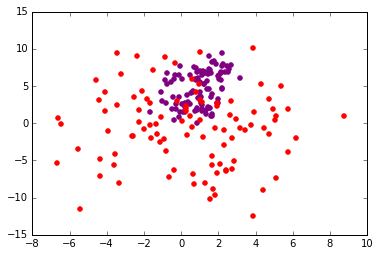

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(thinned_results[:,3], thinned_results[:,14], color="purple")
plt.scatter(true_theta[:,3], true_theta[:,14], color="red")

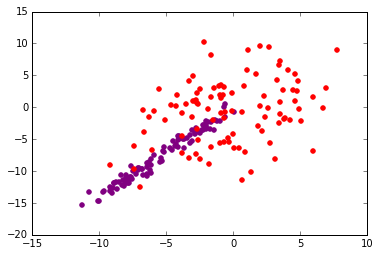

In [62]:
%matplotlib inline
plt.scatter(thinned_results[:,6], thinned_results[:,9], color="purple")
plt.scatter(true_theta[:,1], true_theta[:,14], color="red")

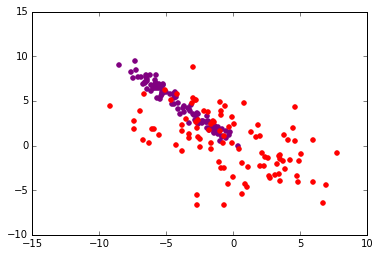

In [66]:
%matplotlib inline
plt.scatter(thinned_results[:,1], thinned_results[:,14], color="purple")
plt.scatter(true_theta[:,1], true_theta[:,3], color="red")

In [57]:
print(A)

[[  5.76532356  -0.41387724   0.49775165   2.333059     3.05827643
    3.35517813  -2.0185811   -2.78665438   0.61501231  -0.09904851
   -0.62526698  -3.10744028  -0.32098343   1.676125    -0.71568172]
 [ -0.41387724  13.73726468   0.81934909  -5.99903786  -5.08066741
    7.50271526   1.58368914   3.26825963   3.67389641  -1.57545
    1.46444571   4.0174603    0.68368336  -6.38193798   7.08211671]
 [  0.49775165   0.81934909  16.56212904   1.30939269   4.92689567
    0.71894587  -1.79254089  -1.59114451  -3.05319732  -1.57670372
   -1.80934183  -3.7857761    6.10571311   3.49316277   2.61665525]
 [  2.333059    -5.99903786   1.30939269  11.1737091    5.17216768
   -3.94013299  -1.89256793  -5.4632819   -1.17667603   2.49329493
    3.64912092  -7.37499071  -2.42321382   3.79061913  -1.23431631]
 [  3.05827643  -5.08066741   4.92689567   5.17216768  24.52362993
   -7.15393775  -1.03980342  -7.19732115  -4.63688419   0.87181248
   -3.49738305  -7.08742153  -2.68077255   6.2796297   -9.107